# Epidemic model, with (almost) no math

The current pandemic is scary, and the outcome of it uncertain. Knowledgeable people do their best to do previsions with the scarce data they have but there is so much you can predict when a lot hinges on political decisions.

There are also a lot of rumors that are ridiculously out of line with reality. This article is an attempt at giving the reader a tool to navigate some claims and understand their ramifications.

I am proposing to build a simple model, called a SIR model. 

A model is a theoretical tool that transforms assumptions into predictions. As always, the core principle of information theory applies: "garbage in, garbage out". It will happily produce wrong previsions if you feed it with wrong assumptions but it allows to explore hypotheses. 

A model is often not a complicated thing. Actually, counter-intuitively, when modelling complicated system, it is often desirable to have very simple models. Let's have a look at SIR:

![](thirdparty/sadasda.png)


Here are the three groups: (S)usceptible, (I)nfected, (R)ecovered, hence the name. Our goal is to model the evolution of an infectious epidemic. We divide the population in 3 big categories: 
- S are people who nevver got the disease and can catch it
- I are people who are infected and contagious
- R are people who are not contagious and not suceptible anymore, either because they built immunity, or because they died. Yes, most people are understandably interested in differenting these two subgroups, but for our modellisation purpose, it is not necessary to add a category for them.

The assumptions of this model are:
- people go from I to R at a constant rate which means a constant percentage of people go from I to R every day.
- people fo from S to I depending on the number of people infected and the proportion of the population that is susceptible.

These assumptions are clearly wrong for the current epidemic. For instance, some people are more isolated and contaminate less people, while some professions are in contact with many other people and spread the disease more. Also, the evolution of the disease is more complex than that and people in hospitals are less in contact with the S group than people who do not show severe symptoms. Yes.

A saying in modelization is that "[All models are wrong, but some are useful](https://en.wikipedia.org/wiki/All_models_are_wrong)". One of the core assumption in SIR is that a model using average values still yield meaningful predictions at the scale of a country.

So in terms of "math" all we need is to attribute a quantity one each arrow. Once these assumptions have been laid clear, it is straightforward for the right arrow, people recovering: I → R is a constant percentage, typically called γ (that's the greek letter gamma. Greek letter is how you name constants to show you are serious about them). That's a percentage of I, so we have:

I → R = γ × I

S → I, the number of new contaminations every day, is a bit more complicated. It depends on three things: 
- The number of people already infected (I)
- The amount of people the population that is suceptible. We call N the total population, so this is S/R
- The average number of people an infected person will contaminate each day. We will call it beta (β) because this one too is serious business.

In the end we multiply all that:

S → I = β × I × S/R

And that's it. No need to compute anything, we got computers for that. We just need to give it initial numbers, these two formulas, and see where it leads us.

So now is some coding. If you just want to see graphs and results, you can skip that part.

# Code

First, some boilerplate code: 
- we instruct jupyter to display graphs in the notebook (`inline`)
- we import `matplotlib` which is a lib to make pretty graphs
- we tell jupyter to make the figures a bit bigger that the typical size.

In [95]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pylab import rcParams

rcParams['figure.figsize'] = 10, 10

Now the real code of the simulation. It takes a bunch of parameters that are self explanatory, iterates for a set amount of days over the two formulas we have determined earlier to produce thress time series: S, I and R which represent the evolution of our three groups in time.

In [112]:
def simu(initS, initI, initR, beta, gamma, max_days=60):
    S=list()
    I=list()
    R=list()
    currentS=initS
    currentI=initI
    currentR=initR
    S.append(currentS)
    I.append(currentI)
    R.append(currentR)
    
    N = initR+initI+initS
    # If a constant is provided for beta, transform it into a list
    if not isinstance(beta, list):
        beta = [beta]*max_days
    for day in range(max_days):
        N = currentS+currentI+currentR
        dS = -beta[day]*currentI*currentS/N
        dI = beta[day]*currentI*currentS/N - gamma*currentI
        dR = gamma*currentI
        currentR += dR
        currentI += dI
        currentS += dS
        S.append(currentS)
        I.append(currentI)
        R.append(currentR)
    return S,I,R

There is a small twist you may have noticed: gamma is a constant parameter, but beta is considered to be a time series as well. This is because one of the point of doing this model is to simulate what happens when populations change their behavior in order to spread the virus less.

Now let's make a plotting function, which is pretty straighforward: give it a list of series and names and let it plot a graph. There is an option to use a logarithmic graph, which I will explain when we toy with these. Matplotlib is a bit messy in how it labels log scales so some a bit obscure code is used there.

In [113]:
def plot(series, labels, logscale=False, xlabel='days'):
    fig, ax = plt.subplots()
    
    for i in range(len(series)):
        t = list(range(len(series[i])))
        ax.plot(t, series[i], label = labels[i])
    if logscale:
        ax.set_yscale('log')
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.axes.ticklabel_format(style='plain', useOffset=False, axis='both')    
    plt.xlabel(xlabel, fontsize=18)
    plt.legend()
    plt.show()

And that's it! Let's try it

# Toying with our model

So, what numbers should we start with? 

- N is straightforwrd: that's the whole population that you are simulating. I'll take 100 millions for now.
- R is zero at the beginning of the simulation: no one has recovered yet.
- I is the number of infected. I'll start with 1
- S is then N-I

Now the parameters, which are our core assumptions.
- γ is straightforward: According to various sources, it takes on average 15 days for someone to not be contagious anymore. So a good guess is around 1/15: if every day you remove a fifteenth of the infected, they'll recover on average in 15 days. 
- β is the crucial one. It determinates how fast and how widely the contagion spreads. At first, I had no idea of what to put there, so I went for 1. Each infected will infect a new person per day.

Now let's see what happens

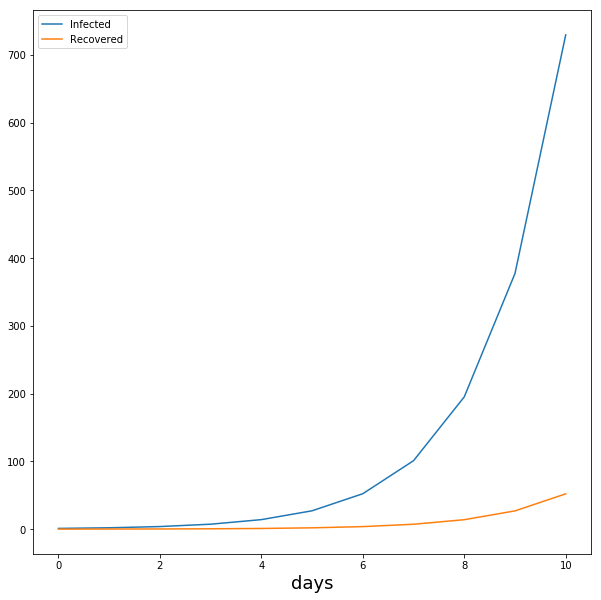

In [114]:
S,I,R = simu(99999999,1,0, 1, 1/15, max_days=10)
plot((I,R), ("Infected", "Recovered"))

Wow! From 1 to 700+ cases in 10 days! That's not exactly what happened. Worldwide, the WHO considers there is a doubling of the epidemic every 6.4 days. There are mathematical methods to calculate β from the doubling duration but why bother? Let's fiddle with it until the graph shows a doubling between 6 and 7 days.

After several attempts, I saw that β = 0.18 did the trick

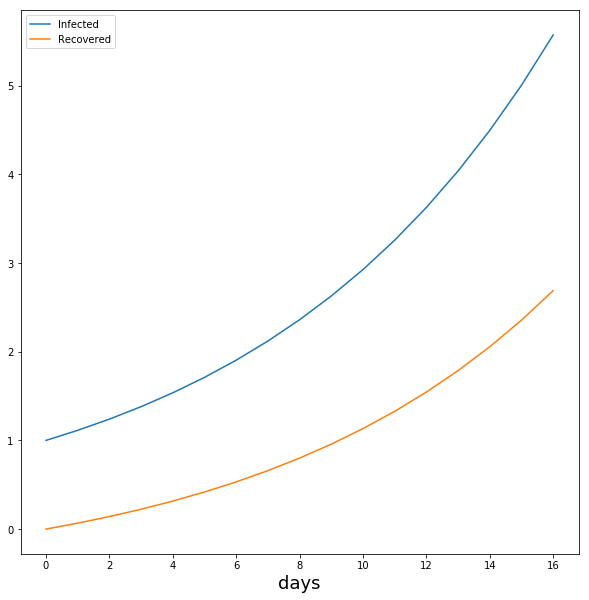

In [115]:
beta = 0.18
gamma = 1/15
S,I,R = simu(99999999,1,0, beta, gamma, max_days=16)
plot((I,R), ("Infected", "Recovered"))

We see that I goes above 2.0 between day #6 and #7. Note that this model considers that our population are floating points values while obviously humans do not come in fractions. Here again, we are just using mathematical models to approximate, at the scale of a big population, the evolution of the disease.

This model makes no sense to study the propagation between a small number of individuals but is useful at the scale of a large population.

So let's see what happens if we start at the 100th patient infected instead.

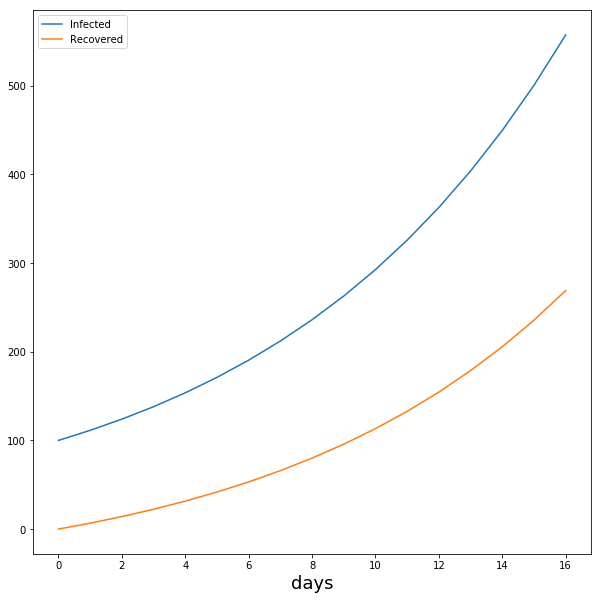

In [100]:
beta = 0.18
gamma = 1/15
S,I,R = simu(99999900,100,0, beta, gamma, max_days=16)
plot((I,R), ("Infected", "Recovered"))

That curve looks oddly similar to the first one, doesn't it? It looks like only the y labels changed. Indeed. In the growing phase of an epidemic, you just get an exponential: the number of infected doubles regularly, so the plot looks the same at all scales. 

Any statistician knows, however, that to make it look more scary, you simply need a diffent scale on the X-axis. Let's plot it on twice more days:

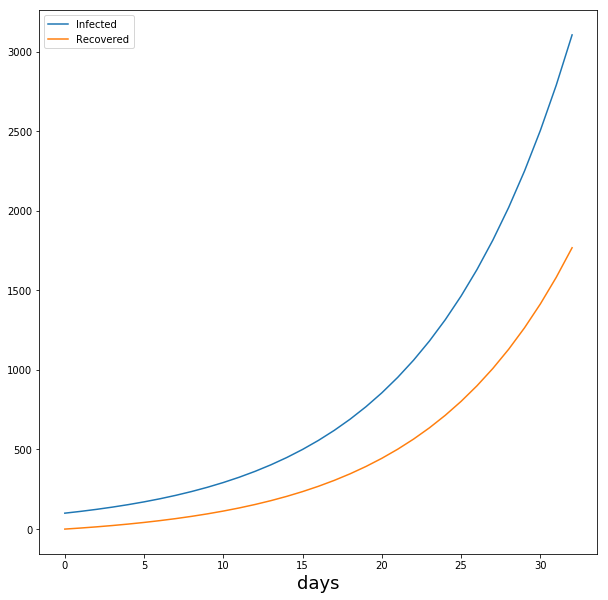

In [101]:
beta = 0.18
gamma = 1/15
S,I,R = simu(99999900,100,0, beta, gamma, max_days=32)
plot((I,R), ("Infected", "Recovered"))

There you go, now with the typical "where will it stop?" air. 

Before we go further, I want to explain something about β. It is the crucial parameter that determines how fast the exponential goes up. Let's run three simulations, with different beta parameters. 

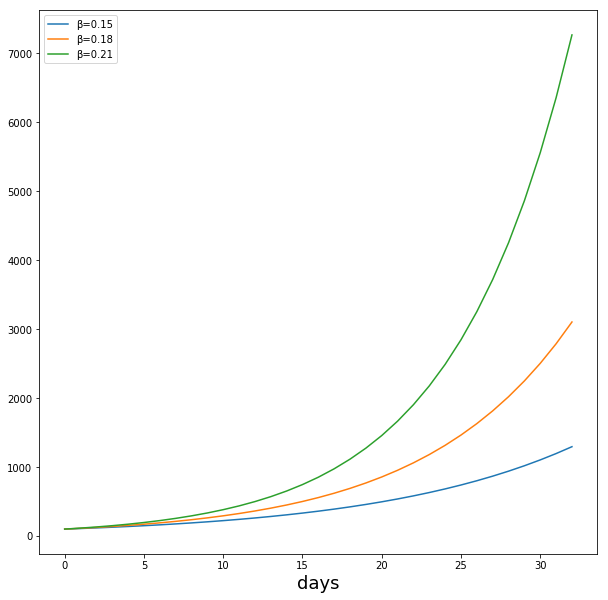

In [102]:
gamma = 1/15

S1,I1,R1 = simu(99999900,100,0, beta = 0.15, gamma=1/15, max_days=32)
S2,I2,R2 = simu(99999900,100,0, beta = 0.18, gamma=1/15, max_days=32)
S3,I3,R3 = simu(99999900,100,0, beta = 0.21, gamma=1/15, max_days=32)

plot([I1,I2,I3], ["β=0.15", "β=0.18", "β=0.21"])

Maybe the β=0.15 country has a climate less liked by the virus, or people bow instead of shaking hands, making people less likely to infect each other. Maybe the β=0.21 country has the custom to kiss on the cheek or a culture of public baths.

This simple number tries to capture all these variables, all these very human characteristics into a single number, in a necessarily over-simplified model, in order to let us do some predictions. 

It also determines if it **goes down** instead of up. Indeed: if each contagious person contaminates on average less than one other person, the result will be a decrease of the `I` population over time. Some people will continue getting infected, but less and less and eventually the epidemic dies out.

To do that, it just needs to be lower than the gamma parameter:

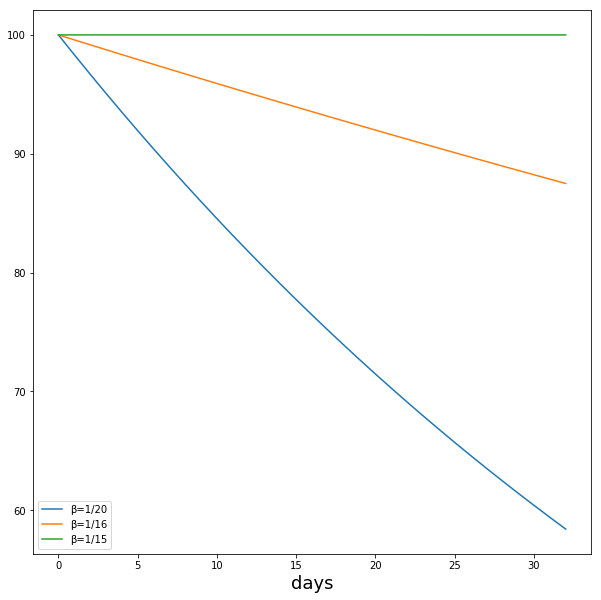

In [103]:
S1,I1,R1 = simu(99999900,100,0, beta = 1/20, gamma=1/15, max_days=32)
S2,I2,R2 = simu(99999900,100,0, beta = 1/16, gamma=1/15, max_days=32)
S3,I3,R3 = simu(99999900,100,0, beta = 1/15, gamma=1/15, max_days=32)

plot([I1,I2,I3], ["β=1/20", "β=1/16", "β=1/15"])

One of the hope of lock-down procedures is to reach that point. 

But even when it goes up, it can't go up forever can it? There is only so many people that can get infected, at one point the suceptible population will be too low to maintain the constant contamination.

Now let's see what happens if we just let the epidemic run its course. Give it a year, and let's add the Susceptible population.

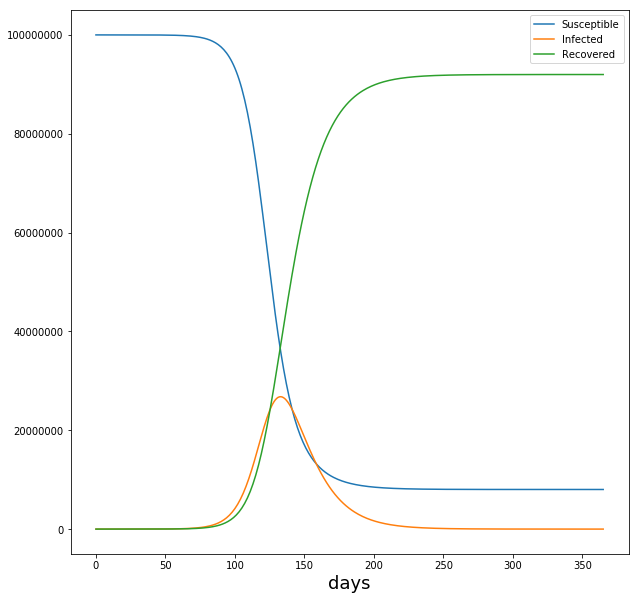

In [104]:
beta = 0.18
gamma = 1/15
S,I,R = simu(99999900,100,0, beta, gamma, max_days=365)
plot((S, I,R), ("Susceptible", "Infected", "Recovered"))


And we see that the part that looked so scary on the previous graphs is now appearing almost flat. Numbers as small as 3000 are nowhere to be seen in this graph that deals in tens of millions. 

It makes sense: the exponential will not start plateauing until it reached a siginificant part of the population. In this simulation it peaks around 26 millions and almost all of the population went through the infectious group (i.e. got the virus).

Now, why not all of them? Well when people who are contagious start being in contact with a lot of people who already recovered (and are therefore immune), they will have a much harder time contaminating new suceptible people. We arrive in the zone where each infected contaminate less than 1 person on average and the epidemic stops. We say that the population has developped herd immunity.

What worries health experts is the peak, around 140 days in this model, where about a quarter of the population is infected. In the case of covid-19, about 14% of them requiring hospitalization and 4% respirators. When places are in the thousands, that's a worrying prospect.

now let's see what happens in our theoretical models with slight changes in beta.

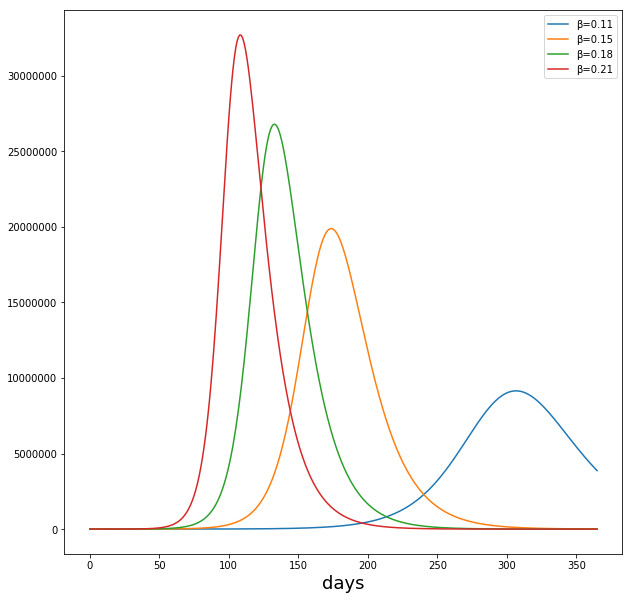

In [105]:
S1,I1,R1 = simu(99999900,100,0, beta = 0.11, gamma=1/15, max_days=365)
S2,I2,R2 = simu(99999900,100,0, beta = 0.15, gamma=1/15, max_days=365)
S3,I3,R3 = simu(99999900,100,0, beta = 0.18, gamma=1/15, max_days=365)
S4,I4,R4 = simu(99999900,100,0, beta = 0.21, gamma=1/15, max_days=365)

plot([I1,I2,I3,I4], ["β=0.11", "β=0.15", "β=0.18", "β=0.21"])

So that's what is meant when people talk about "flattening the curve". Getting the beta lower both delays the peak and lowers its maximum. Even by simply halving the number of contacts people have (i.e. "social distancing") the effect on the dynamics of the epidemic is enormous. Even an imperfect containment, even an insufficient effort, does have an overall effect.

There is also another effect to a lower beta:

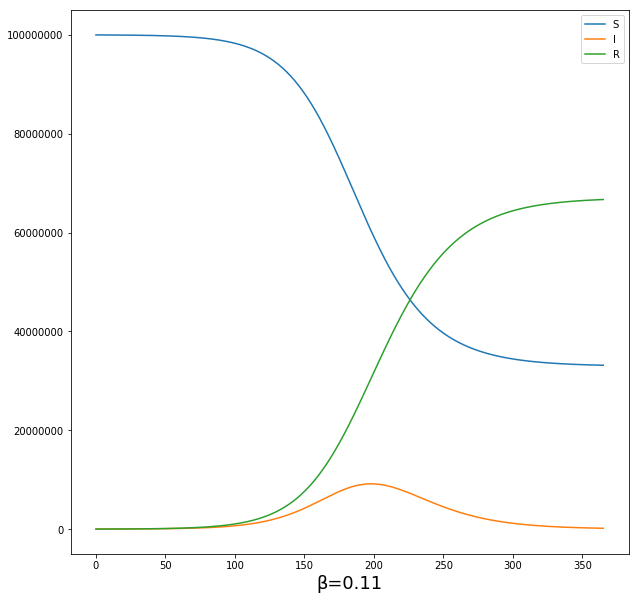

In [106]:
S1,I1,R1 = simu(99990000,10000,0, beta = 0.11, gamma=1/15, max_days=365)

plot([S1,I1,R1], ["S","I", "R"], xlabel="β=0.11")

A bigger part of the population never gets sick before herd immunity kicks in. That' also a plus.

(Note: I made this simulation start at 10 000 infected, to shift the graph a bit to the left)

But still like this, the peak remains scary. One of our desire is to contain the epidemic. So let's try to simulate the effect that a containment policy could have. 

For that we make beta change at one time instead of being a constant. Let's assume we are in a global-average country of beta=0.18 and that by day 80, the government enforces a policy that divides beta by two.

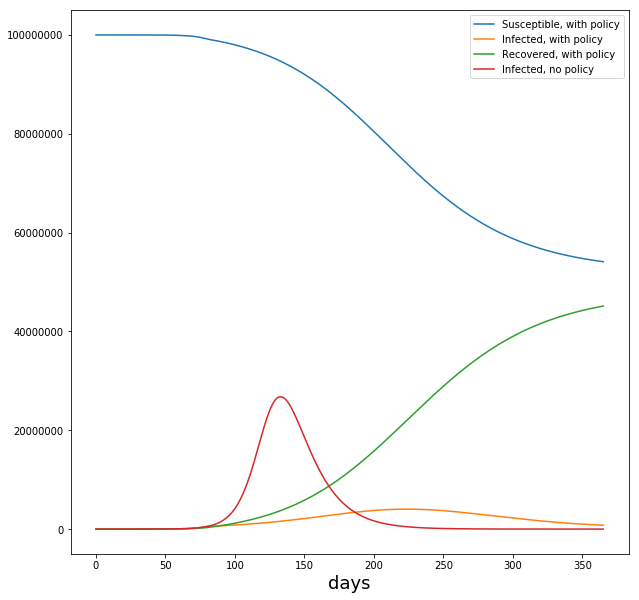

In [107]:
beta = [0.18]*80+[0.09]*400

S,I,R = simu(99999900,100,0, beta, gamma=1/15, max_days=365)
S2,I2,R2 = simu(99999900,100,0, beta=0.18, gamma=1/15, max_days=365)

plot([S, I, R, I2], ["Susceptible, with policy", "Infected, with policy", "Recovered, with policy", "Infected, no policy"])

Let's zoom a bit on the infected alone:

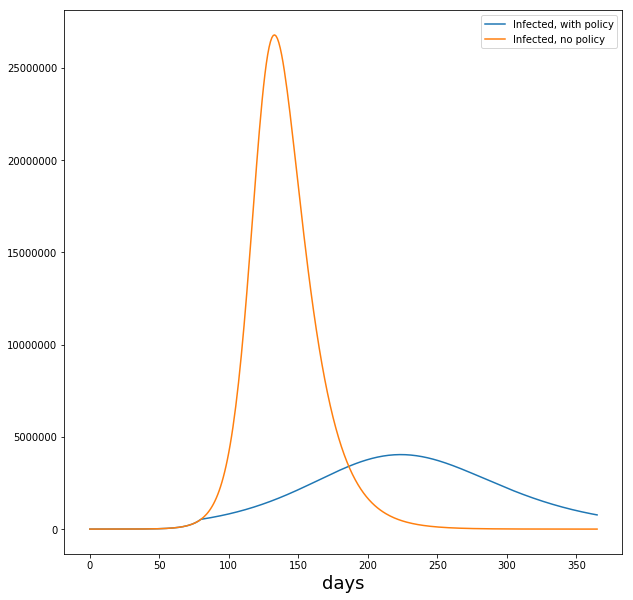

In [108]:
plot([I, I2], ["Infected, with policy", "Infected, no policy"])

It does produce a peak at 10 times the number of infected compared to the time the policy started. It did some mitigation of damage though. Was it a failure?

What most people want to see is a policy that manages to keep the numbers low enough and to kill the epidemic quicker:

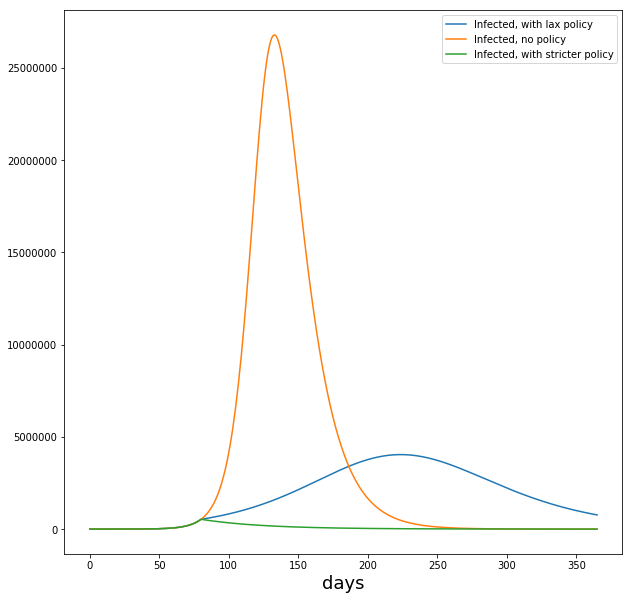

In [109]:
beta = [0.18]*80+[0.045]*400

S3,I3,R3 = simu(99999900,100,0, beta, gamma=1/15, max_days=365)

plot([I, I2, I3], ["Infected, with lax policy", "Infected, no policy", "Infected, with stricter policy"])

It is a very different world if you manage to not rely on herd immunity to solve this problem. 

We can be out of it in a matter of months with appropriate quarantine measures. Half-hearted mitigation could make this linger for more than a year and not caring at all would cause millions of death.

Oh, and as a last exercise, let's add a different scenario, that was proposed by a cynical friend: what would happen if a country would implement a lax policy and abandon it too early? For instance as soon as the infected population starts getting lower, around day 250?

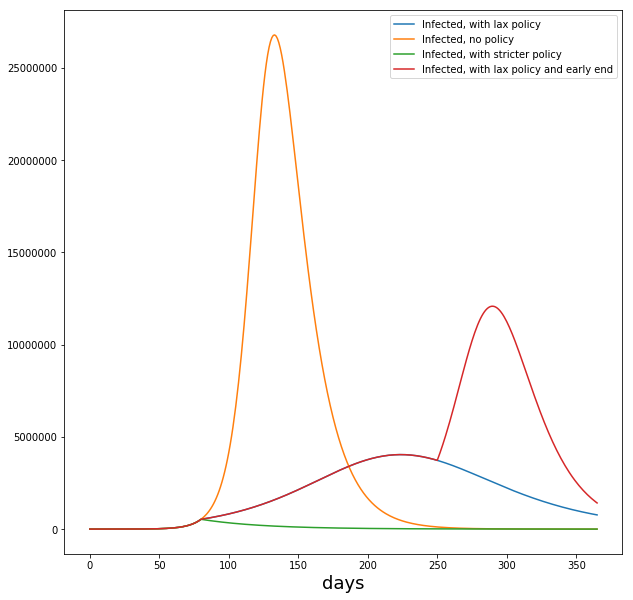

In [111]:
beta = [0.18]*80+[0.09]*(250-80)+[0.18]*300

S4,I4,R4 = simu(99999900,100,0, beta, gamma=1/15, max_days=365)
plot([I, I2, I3, I4], ["Infected, with lax policy", "Infected, no policy", "Infected, with stricter policy", "Infected, with lax policy and early end"])

Hmmm, being a cynic does not bring very pleasant thoughts...